# LLM Decoding Strategy Analysis

### Environment and Imports

In [1]:
# %%capture
!pip install transformers accelerate datasets torch
!pip install numpy pandas matplotlib seaborn

import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup for Reproducibility (Crucial for the Report)
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 34.5 MB/s eta 0:00:00:00:0100:01
  Attempting un

### Models and Dataset

In [2]:
# 1. Load the Generation Model (SmolLM2-135M-SFT-Only)
model_id = "HuggingFaceTB/SmolLM2-135M-SFT-Only"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

# Ensure pad token is set (critical for batch generation later)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 2. Load the Reward Model (The "Judge")
# We use this to objectively score "Quality" for the report analysis
rm_id = "OpenAssistant/reward-model-deberta-v3-large-v2"
rm_tokenizer = AutoTokenizer.from_pretrained(rm_id)
reward_model = AutoModelForSequenceClassification.from_pretrained(rm_id).to(device)

# 3. Load & Filter the Dataset
# We take a specific subset to ensure our experiments are fast but statistically significant
ds = load_dataset("HuggingFaceH4/instruction-dataset", split="test")

# Select 50 distinct prompts for the 'Across-Prompt' analysis
prompts = ds.shuffle(seed=42).select(range(50))['prompt']

print(f"✅ Models loaded on {device}")
print(f"✅ Loaded {len(prompts)} test prompts. Example: '{prompts[0][:50]}...'")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/199 [00:00<?, ?B/s]

step3-eval.jsonl: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/327 [00:00<?, ? examples/s]

✅ Models loaded on cuda
✅ Loaded 50 test prompts. Example: 'Write a short analysis of the cinematography in th...'


### Decoding Class

In [3]:
class DecodingStrategies:
    def __init__(self, model, tokenizer, device='cuda'):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def greedy_search(self, input_ids, max_new_tokens=50):
        # Implementation of Greedy Search [cite: 84]
        # Always selects the token with the highest probability
        curr_ids = input_ids.clone()

        for _ in range(max_new_tokens):
            with torch.no_grad():
                outputs = self.model(curr_ids)
                next_token_logits = outputs.logits[:, -1, :]
                # Select token with max probability (argmax)
                next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)
                curr_ids = torch.cat([curr_ids, next_token], dim=-1)

                if next_token.item() == self.tokenizer.eos_token_id:
                    break
        return curr_ids

    def top_k_sampling(self, input_ids, max_new_tokens=50, k=50, temperature=1.0):
        # Implementation of Top-K Sampling [cite: 94]
        # Restricts sampling to the K most likely tokens
        curr_ids = input_ids.clone()

        for _ in range(max_new_tokens):
            with torch.no_grad():
                outputs = self.model(curr_ids)
                # Apply Temperature: Higher T flattens distribution (more random)
                logits = outputs.logits[:, -1, :] / temperature

                # Filter: Keep only top K, mask others with -inf
                top_k_logits, top_k_indices = torch.topk(logits, k)
                
                # Create a mask of -inf for all non-top-k tokens
                mask = torch.full_like(logits, float('-inf'))
                mask.scatter_(1, top_k_indices, top_k_logits)
                
                # Sample from the filtered distribution
                probs = F.softmax(mask, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                
                curr_ids = torch.cat([curr_ids, next_token], dim=-1)
                if next_token.item() == self.tokenizer.eos_token_id:
                    break
        return curr_ids

    def top_p_sampling(self, input_ids, max_new_tokens=50, p=0.9, temperature=1.0):
        # Implementation of Top-P (Nucleus) Sampling [cite: 98]
        # Selects smallest set of tokens whose cumulative prob > p
        curr_ids = input_ids.clone()

        for _ in range(max_new_tokens):
            with torch.no_grad():
                outputs = self.model(curr_ids)
                logits = outputs.logits[:, -1, :] / temperature
                
                # Sort logits descending to calculate cumulative probability
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                # Create mask: Remove tokens AFTER the cumulative sum exceeds p
                # We shift the mask right by 1 to include the first token that crosses the threshold
                sorted_indices_to_remove = cumulative_probs > p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                # Scatter the mask back to the original indices
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                logits[indices_to_remove] = float('-inf')

                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                
                curr_ids = torch.cat([curr_ids, next_token], dim=-1)
                if next_token.item() == self.tokenizer.eos_token_id:
                    break
        return curr_ids

    def beam_search(self, input_ids, max_new_tokens=50, beam_width=5):
        # Implementation of Beam Search [cite: 88]
        # Maintains 'beam_width' concurrent sequences
        
        # Candidate List: List of tuples (score, sequence_tensor)
        candidates = [(0.0, input_ids)]
        
        for _ in range(max_new_tokens):
            all_expansions = []
            
            # Expand each candidate
            for score, seq in candidates:
                if seq[0, -1].item() == self.tokenizer.eos_token_id:
                    all_expansions.append((score, seq)) # Keep finished sequences
                    continue
                    
                with torch.no_grad():
                    outputs = self.model(seq)
                    # Get log probabilities (score is cumulative log prob)
                    next_token_logits = outputs.logits[:, -1, :]
                    next_token_probs = F.log_softmax(next_token_logits, dim=-1)
                    
                    # Optimization: Only consider top beam_width tokens per branch to save compute
                    top_scores, top_tokens = torch.topk(next_token_probs, beam_width)
                    
                    for i in range(beam_width):
                        token = top_tokens[0, i].unsqueeze(0).unsqueeze(0)
                        token_score = top_scores[0, i].item()
                        new_seq = torch.cat([seq, token], dim=-1)
                        all_expansions.append((score + token_score, new_seq))
            
            # Prune: Keep only the top 'beam_width' candidates globally
            # Sort by score (descending)
            ordered = sorted(all_expansions, key=lambda x: x[0], reverse=True)
            candidates = ordered[:beam_width]
            
            # Stop if all beams hit EOS (optional, but good for speed)
            if all(c[1][0, -1].item() == tokenizer.eos_token_id for c in candidates):
                break
                
        # Return the single best sequence
        return candidates[0][1]

# Instantiate the decoder helper
decoder = DecodingStrategies(model, tokenizer, device)
print("✅ Decoding strategies implemented.")

✅ Decoding strategies implemented.


### Metrics

In [4]:
def calculate_distinct_n(texts, n=2):
    """
    Calculates Distinct-N: unique_ngrams / total_ngrams [cite: 105]
    """
    total_ngrams = 0
    unique_ngrams = set()
    
    for text in texts:
        tokens = text.split() # Simple whitespace tokenization for metrics
        if len(tokens) < n:
            continue
        ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        unique_ngrams.update(ngrams)
        total_ngrams += len(ngrams)
    
    if total_ngrams == 0: return 0.0
    return len(unique_ngrams) / total_ngrams

def get_reward_score(texts, prompts):
    """
    Uses the loaded Reward Model to score quality.
    Input: Generated texts and their corresponding prompts.
    """
    scores = []
    # Process in small batches to avoid OOM
    for i in range(len(texts)):
        # The reward model expects "Question: [prompt] Answer: [response]" format
        # usually, but for this specific RM, we just feed the full text.
        full_input = prompts[i] + texts[i]
        inputs = rm_tokenizer(full_input, return_tensors="pt", truncation=True, max_length=512).to(device)
        
        with torch.no_grad():
            score = reward_model(**inputs).logits[0].item()
        scores.append(score)
    return np.mean(scores)

print("✅ Metric functions ready.")

✅ Metric functions ready.


## Temperature Grid Search

In [5]:
import pandas as pd
import time

# Configuration
temperatures = [0.2, 0.5, 0.8, 1.0, 1.2]
results_summary = []

print(f"Starting Experiment A on {len(prompts)} prompts...")

# --- 1. RUN BASELINES (Temperature Invariant) ---
print("\nRunning Baselines (Greedy & Beam)...")

# Containers for generated text
greedy_texts = []
beam_texts = []

start_time = time.time()
for i, prompt in enumerate(prompts):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    
    # Greedy
    out_g = decoder.greedy_search(input_ids, max_new_tokens=50)
    # We strip the prompt to analyze ONLY the generated new tokens
    gen_text_g = tokenizer.decode(out_g[0], skip_special_tokens=True)[len(prompt):]
    greedy_texts.append(gen_text_g)
    
    # Beam (Width=5)
    out_b = decoder.beam_search(input_ids, max_new_tokens=50, beam_width=5)
    gen_text_b = tokenizer.decode(out_b[0], skip_special_tokens=True)[len(prompt):]
    beam_texts.append(gen_text_b)

# Calculate Metrics for Baselines
metrics_g = {
    "Strategy": "Greedy",
    "Temp": 0.0, # Placeholder
    "Distinct-2": calculate_distinct_n(greedy_texts, n=2),
    "Reward": get_reward_score(greedy_texts, prompts)
}
metrics_b = {
    "Strategy": "Beam Search",
    "Temp": 0.0, # Placeholder
    "Distinct-2": calculate_distinct_n(beam_texts, n=2),
    "Reward": get_reward_score(beam_texts, prompts)
}
results_summary.append(metrics_g)
results_summary.append(metrics_b)
print(f"✅ Baselines Done. Greedy Reward: {metrics_g['Reward']:.2f}, Beam Reward: {metrics_b['Reward']:.2f}")


# --- 2. RUN TEMPERATURE GRID (Top-K & Top-P) ---
print("\nRunning Temperature Grid (Top-K & Top-P)...")

for t in temperatures:
    k_texts = []
    p_texts = []
    
    for prompt in prompts:
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
        
        # Top-K (K=50)
        out_k = decoder.top_k_sampling(input_ids, k=50, temperature=t)
        gen_text_k = tokenizer.decode(out_k[0], skip_special_tokens=True)[len(prompt):]
        k_texts.append(gen_text_k)
        
        # Top-P (P=0.9)
        out_p = decoder.top_p_sampling(input_ids, p=0.9, temperature=t)
        gen_text_p = tokenizer.decode(out_p[0], skip_special_tokens=True)[len(prompt):]
        p_texts.append(gen_text_p)
        
    # Calculate Metrics for this Temp
    # Top-K
    metrics_k = {
        "Strategy": "Top-K",
        "Temp": t,
        "Distinct-2": calculate_distinct_n(k_texts, n=2),
        "Reward": get_reward_score(k_texts, prompts)
    }
    results_summary.append(metrics_k)
    
    # Top-P
    metrics_p = {
        "Strategy": "Top-P",
        "Temp": t,
        "Distinct-2": calculate_distinct_n(p_texts, n=2),
        "Reward": get_reward_score(p_texts, prompts)
    }
    results_summary.append(metrics_p)
    
    print(f"  Temp {t}: Top-K Div={metrics_k['Distinct-2']:.2f} | Top-P Div={metrics_p['Distinct-2']:.2f}")

# --- 3. SAVE RESULTS ---
df_results = pd.DataFrame(results_summary)
print("\n Experiment A Complete! Here is the summary data for Table 1:")
print(df_results)

Starting Experiment A on 50 prompts...

Running Baselines (Greedy & Beam)...
✅ Baselines Done. Greedy Reward: -2.55, Beam Reward: -2.62

Running Temperature Grid (Top-K & Top-P)...
  Temp 0.2: Top-K Div=0.71 | Top-P Div=0.67
  Temp 0.5: Top-K Div=0.75 | Top-P Div=0.75
  Temp 0.8: Top-K Div=0.89 | Top-P Div=0.87
  Temp 1.0: Top-K Div=0.93 | Top-P Div=0.89
  Temp 1.2: Top-K Div=0.92 | Top-P Div=0.98

 Experiment A Complete! Here is the summary data for Table 1:
       Strategy  Temp  Distinct-2    Reward
0        Greedy   0.0    0.732118 -2.546419
1   Beam Search   0.0    0.656347 -2.620424
2         Top-K   0.2    0.708844 -2.602289
3         Top-P   0.2    0.669725 -2.879767
4         Top-K   0.5    0.746521 -2.768635
5         Top-P   0.5    0.752822 -2.558355
6         Top-K   0.8    0.891621 -3.049405
7         Top-P   0.8    0.866375 -2.517591
8         Top-K   1.0    0.931702 -3.354303
9         Top-P   1.0    0.885439 -3.046599
10        Top-K   1.2    0.918019 -3.267008
11      

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

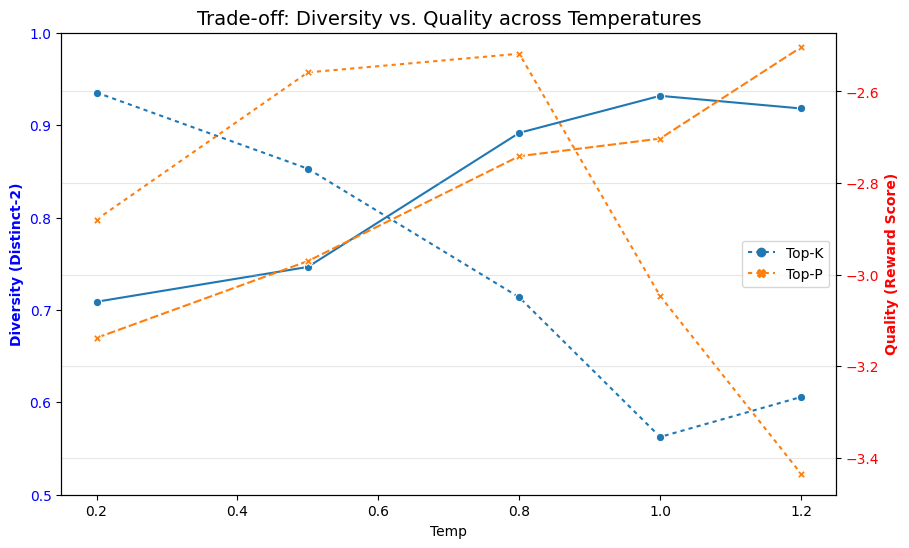

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tradeoff(df):
    # Filter for sampling methods only (since Baselines have no Temp)
    df_sampling = df[df["Strategy"].isin(["Top-K", "Top-P"])]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot Diversity (Left Axis)
    sns.lineplot(data=df_sampling, x="Temp", y="Distinct-2", hue="Strategy", 
                 style="Strategy", markers=True, ax=ax1, legend=False)
    ax1.set_ylabel("Diversity (Distinct-2)", color="blue", fontweight='bold')
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.set_ylim(0.5, 1.0)
    
    # Create Right Axis for Reward (Quality)
    ax2 = ax1.twinx()
    sns.lineplot(data=df_sampling, x="Temp", y="Reward", hue="Strategy", 
                 style="Strategy", markers=True, dashes=[(2,2), (2,2)], ax=ax2)
    ax2.set_ylabel("Quality (Reward Score)", color="red", fontweight='bold')
    ax2.tick_params(axis='y', labelcolor="red")
    
    plt.title("Trade-off: Diversity vs. Quality across Temperatures", fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Custom Legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right')
    
    plt.show()

plot_tradeoff(df_results)

## Within-Prompt Diversity

In [8]:
# --- EXPERIMENT B: REFINED (Sanity Check) ---
import pandas as pd

# Configuration
TEMP = 0.8
N_SAMPLES = 20
fixed_prompt = prompts[0] 
varied_prompts = prompts[:N_SAMPLES]

print(f"Re-running Experiment B (Rigorous Mode) at T={TEMP}...")
print(f"   Target Prompt for 'Within' test: '{fixed_prompt[:40]}...'\n")

collapse_results = []

for strategy in ["Top-K", "Top-P"]:
    print(f"--- Testing {strategy} ---")
    
    # 1. WITHIN-PROMPT (Same Input -> 20 Outputs)
    within_texts = []
    input_ids = tokenizer(fixed_prompt, return_tensors="pt").input_ids.to(device)
    input_len = input_ids.shape[1] # Store exact token length
    
    for _ in range(N_SAMPLES):
        if strategy == "Top-K":
            out = decoder.top_k_sampling(input_ids, k=50, temperature=TEMP)
        else:
            out = decoder.top_p_sampling(input_ids, p=0.9, temperature=TEMP)
            
        # SAFE DECODING: Slice tokens first, then decode
        new_tokens = out[0][input_len:]
        text = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()
        within_texts.append(text)
    
    div_within = calculate_distinct_n(within_texts, n=2)
    
    # 2. ACROSS-PROMPT (20 Inputs -> 1 Output Each)
    across_texts = []
    print(f"   [Inspection] First 3 'Across' outputs for {strategy}:") 
    
    for i, prompt in enumerate(varied_prompts):
        p_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
        p_len = p_ids.shape[1]
        
        if strategy == "Top-K":
            out = decoder.top_k_sampling(p_ids, k=50, temperature=TEMP)
        else:
            out = decoder.top_p_sampling(p_ids, p=0.9, temperature=TEMP)
            
        new_tokens = out[0][p_len:]
        text = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()
        across_texts.append(text)
        
        # Print first 3 to spot "Boilerplate" repetition
        if i < 3:
            print(f"     {i+1}. {text[:60]}...")
        
    div_across = calculate_distinct_n(across_texts, n=2)
    
    # Store
    collapse_results.append({"Strategy": strategy, "Condition": "Within-Prompt", "Distinct-2": div_within})
    collapse_results.append({"Strategy": strategy, "Condition": "Across-Prompt", "Distinct-2": div_across})
    
    print(f"   -> Within Div: {div_within:.3f} | Across Div: {div_across:.3f}\n")

df_collapse_refined = pd.DataFrame(collapse_results)
print("✅ Refined Experiment B Complete.")
print(df_collapse_refined)

Re-running Experiment B (Rigorous Mode) at T=0.8...
   Target Prompt for 'Within' test: 'Write a short analysis of the cinematogr...'

--- Testing Top-K ---
   [Inspection] First 3 'Across' outputs for Top-K:
     1. Output:...
     2. * Software Engineer
* Software Developer/IT Professional
* S...
     3. ...
   -> Within Div: 0.888 | Across Div: 0.901

--- Testing Top-P ---
   [Inspection] First 3 'Across' outputs for Top-P:
     1. 5
 Output:...
     2. 1. Your name. 2. Your profession. 3. Your job title. 4. Your...
     3. ...
   -> Within Div: 0.967 | Across Div: 0.882

✅ Refined Experiment B Complete.
  Strategy      Condition  Distinct-2
0    Top-K  Within-Prompt    0.887640
1    Top-K  Across-Prompt    0.900804
2    Top-P  Within-Prompt    0.966667
3    Top-P  Across-Prompt    0.881844


In [11]:
# --- QUALITATIVE ANALYSIS (FINAL FIX) ---
# We use the Chat Template so the model understands the input structure.

# 1. Prepare the input as a structured message
messages = [{"role": "user", "content": "Explain the concept of 'entropy' to a 5-year-old using an analogy."}]

# 2. Apply the specific chat template for SmolLM (handles <|im_start|>, etc.)
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)
input_len = input_ids.shape[1]

print(f"📝 Generating Qualitative Samples (Input Shape: {input_ids.shape})...\n")

# 1. Greedy
out_g = decoder.greedy_search(input_ids, max_new_tokens=100)
new_tokens_g = out_g[0][input_len:]
text_g = tokenizer.decode(new_tokens_g, skip_special_tokens=True).strip()
print(f"🔹 GREEDY:\n{text_g}\n")

# 2. Beam Search
out_b = decoder.beam_search(input_ids, max_new_tokens=100, beam_width=5)
new_tokens_b = out_b[0][input_len:]
text_b = tokenizer.decode(new_tokens_b, skip_special_tokens=True).strip()
print(f"🔹 BEAM SEARCH:\n{text_b}\n")

# 3. Top-K
out_k = decoder.top_k_sampling(input_ids, k=50, temperature=0.8, max_new_tokens=100)
new_tokens_k = out_k[0][input_len:]
text_k = tokenizer.decode(new_tokens_k, skip_special_tokens=True).strip()
print(f"🔹 TOP-K (T=0.8):\n{text_k}\n")

# 4. Top-P
out_p = decoder.top_p_sampling(input_ids, p=0.9, temperature=0.8, max_new_tokens=100)
new_tokens_p = out_p[0][input_len:]
text_p = tokenizer.decode(new_tokens_p, skip_special_tokens=True).strip()
print(f"🔹 TOP-P (T=0.8):\n{text_p}\n")

📝 Generating Qualitative Samples (Input Shape: torch.Size([1, 24]))...

🔹 GREEDY:
assistant
Imagine you have a big box of crayons. Each crayon has a different color, and you want to put them all together in a big pile. But, you also want to make sure that each crayon has a unique color, so you put them in a way that they don't mix together.

The "entropy" in this analogy is like the leftover crayons that are leftover from the big pile. You put them all together in a pile, but you also want

🔹 BEAM SEARCH:
assistant
Imagine you have a big box of crayons. Each crayon has a different color - red, blue, green, and yellow. Now, if you take all the crayons and put them in a big pile, you might end up with a big pile of red crayons, a big pile of blue crayons, a big pile of green crayons, and a big pile of yellow crayons.

But here's the weird part: if you take all the yellow crayons and put them in

🔹 TOP-K (T=0.8):
assistant
Imagine you have a big box full of toys, but they're all so differ